In [1]:
import sys
sys.path.append('/Users/yuch8913/miniforge3/envs/er3t_env/lib/python3.8/site-packages')
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from glob import glob
import numpy as np
from sys import exit as ext
import copy
from bisect import bisect_left
from oco_post_class_ywc import *
from matplotlib import cm
from scipy.interpolate import interpn
from scipy import stats
import geopy.distance
import xarray as xr
import seaborn as sns
from tool_code import *
%matplotlib inline
import os, pickle 
#"""

from matplotlib import font_manager

font_path = '/System/Library/Fonts/Supplemental/Arial.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#"""

import warnings
warnings.filterwarnings("ignore")

In [27]:
data_1 = pd.read_pickle('cld_slope_inter_central_asia_20181018.pkl')
data_2 = pd.read_pickle('cld_slope_inter_central_asia_20181018_2.pkl')
data_3 = pd.read_pickle('cld_slope_inter_amazon_20170605.pkl')
data_4 = pd.read_pickle('cld_slope_inter_australia_20170721.pkl')
data_5 = pd.read_pickle('cld_slope_inter_australia_20190621_1.pkl')
data_6 = pd.read_pickle('cld_slope_inter_australia_20190621_2.pkl')

In [28]:
data_1

,lon,lat,cld_dis,o2a_slope,o2a_inter,wco2_slope,wco2_inter,sco2_slope,sco2_inter,o2a_continuum_3d,o2a_continuum_clr,wco2_continuum_3d,wco2_continuum_clr,sco2_continuum_3d,sco2_continuum_clr
0,55.25125,32.15125,2.155564,0.195010,0.017410,0.109421,0.015103,0.145107,-0.001332,0.065992,0.062826,0.018288,0.017561,0.005682,0.005582
1,55.25125,32.15875,1.988644,0.104436,0.031551,0.095046,0.020919,0.092377,0.010253,0.065335,0.062340,0.018170,0.017385,0.005673,0.005518
2,55.25125,32.16625,1.848421,0.045307,0.045197,0.142757,0.015267,0.091765,0.014361,0.065293,0.062063,0.018207,0.017356,0.005705,0.005531
3,55.25125,32.17375,1.741356,0.070969,0.059811,0.217784,0.009837,0.060918,0.023484,0.066657,0.062305,0.018662,0.017601,0.005795,0.005599
4,55.25125,32.18125,1.673824,0.015625,0.084718,0.148399,0.034174,0.061010,0.033417,0.066188,0.061031,0.018470,0.017226,0.005767,0.005523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18075,56.09125,33.31375,18.304376,0.026314,0.021186,0.110146,-0.002498,-0.013543,0.015647,0.056527,0.054874,0.017013,0.016651,0.005189,0.005139
18076,56.09125,33.32125,18.494314,-0.018400,0.029534,0.060258,0.008144,0.000551,0.014608,0.056214,0.054555,0.016832,0.016443,0.005233,0.005163
18077,56.09125,33.32875,18.686434,0.043929,0.025246,0.066402,0.009895,0.047688,0.005797,0.055596,0.053775,0.016679,0.016290,0.005121,0.005079
18078,56.09125,33.33625,18.880671,0.122717,0.015646,0.141600,-0.000602,0.100741,-0.000175,0.056989,0.055121,0.017167,0.016640,0.005207,0.005129


In [165]:
print(data_1.shape)
print(data_2.shape)
df_all = data_1.append(data_2, ignore_index=True)
#df_all = df_all.append(data_3, ignore_index=True)
#df_all = df_all.append(data_4, ignore_index=True)
#df_all = df_all.append(data_5, ignore_index=True)
df_all = df_all.append(data_6, ignore_index=True)
print(df_all.shape)

df_all = data_1.copy()

(18080, 15)
(8000, 15)
(61996, 15)


In [58]:
def heatmap_xy(x, y, ax):
    from matplotlib.colors import LogNorm
    light_jet = cmap_map(lambda x: x/3*2 + 0.33, cm.jet)
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x, y = x[mask], y[mask]
    # Calculate the point density
    data , x_e, y_e = np.histogram2d(x, y, bins=15)#, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    z[np.where(np.isinf(z))] = np.nanmax(z)
    z[np.where(z<0)] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    plot_x, plot_y, z = np.array(x)[idx], np.array(y)[idx], z[idx]
    #ax.scatter(plot_x, plot_y, c=z, s=15*z/np.nanmax(z), cmap=light_jet)
    ax.scatter(plot_x, plot_y, s=3, c='k')
    #ax.hist2d(plot_x, plot_y, bins=150, norm=LogNorm(), cmap=light_jet)
    out = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    sns.kdeplot(out, x='x', y='y', cmap='hot_r', n_levels=20, fill=True, ax=ax, alpha=0.65)
    return plot_x, plot_y, z

In [57]:
"""
def heatmap_xy(x, y, ax):
    from matplotlib.colors import LogNorm
    light_jet = cmap_map(lambda x: x/3*2 + 0.33, cm.jet)
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x, y = x[mask], y[mask]
    # Calculate the point density
    data , x_e, y_e = np.histogram2d(x, y, bins=150)#, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    z[np.where(np.isinf(z))] = np.nanmax(z)
    z[np.where(z<0)] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    plot_x, plot_y, z = np.array(x)[idx], np.array(y)[idx], z[idx]
    #ax.scatter(plot_x, plot_y, c=z, s=15*z/np.nanmax(z), cmap=light_jet)
    #ax.scatter(plot_x, plot_y, s=3, c='k')
    ax.hist2d(plot_x, plot_y, bins=150, norm=LogNorm(), cmap=light_jet)
    #out = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    #sns.kdeplot(out, x='x', y='y', cmap='hot_r', n_levels=20, fill=True, ax=ax, alpha=0.65)
    return plot_x, plot_y, z
#"""

'\ndef heatmap_xy(x, y, ax):\n    from matplotlib.colors import LogNorm\n    light_jet = cmap_map(lambda x: x/3*2 + 0.33, cm.jet)\n    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))\n    x, y = x[mask], y[mask]\n    # Calculate the point density\n    data , x_e, y_e = np.histogram2d(x, y, bins=150)#, density=True)\n    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)\n    z[np.where(np.isnan(z))] = 0.0\n    z[np.where(np.isinf(z))] = np.nanmax(z)\n    z[np.where(z<0)] = 0.0\n    # Sort the points by density, so that the densest points are plotted last\n    idx = z.argsort()\n    plot_x, plot_y, z = np.array(x)[idx], np.array(y)[idx], z[idx]\n    #ax.scatter(plot_x, plot_y, c=z, s=15*z/np.nanmax(z), cmap=light_jet)\n    #ax.scatter(plot_x, plot_y, s=3, c=\'k\')\n    ax.hist2d(plot_x, plot_y, bins=150, norm=LogNorm(), cmap=light_jet)\n    #out = pd.DataFrame(np.array([x, y]).T, columns=[\'x

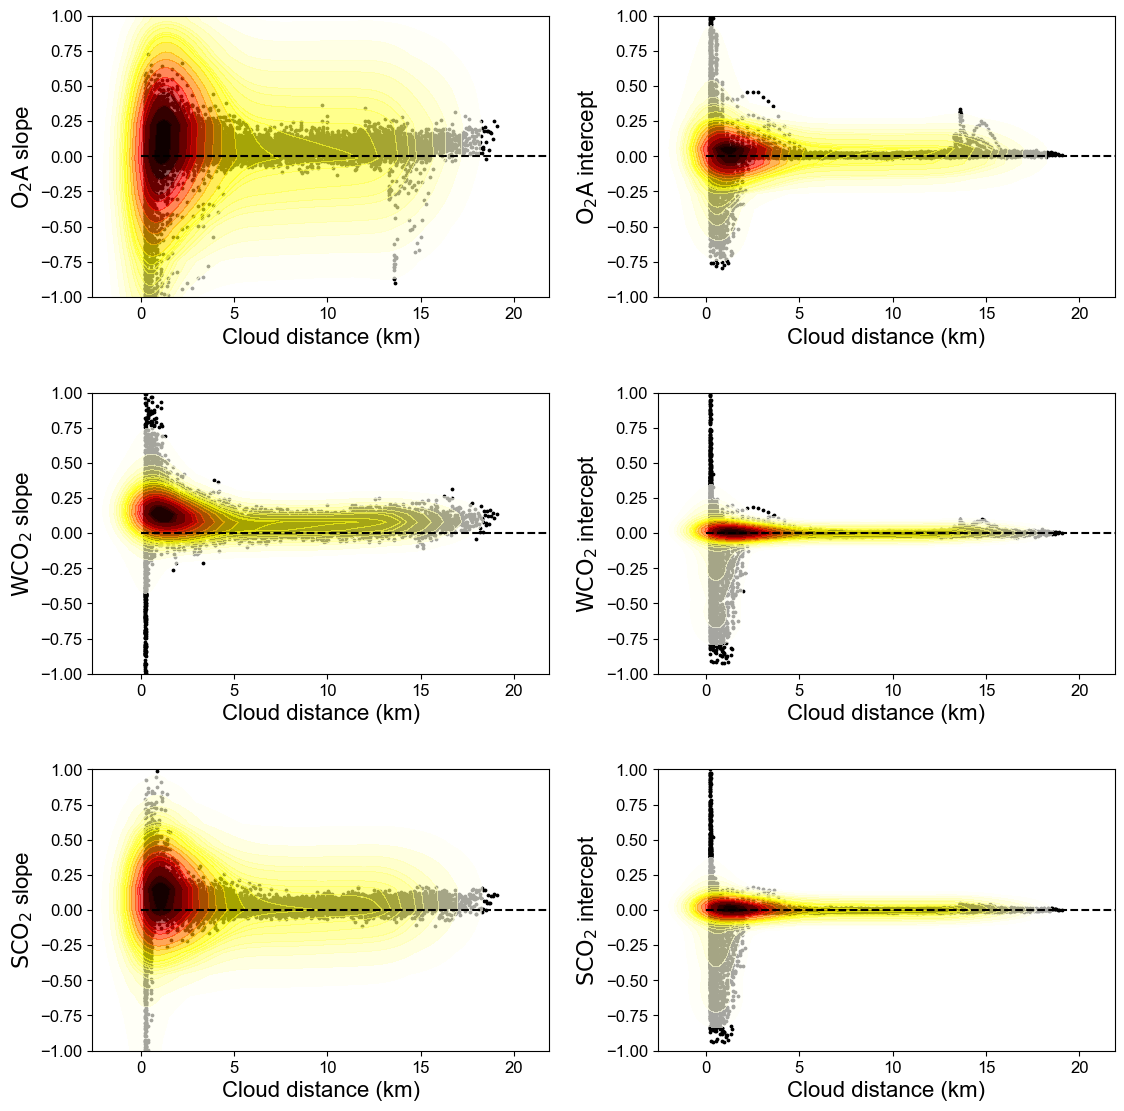

In [59]:
fig, ((ax11, ax12), 
      (ax21, ax22),
      (ax31, ax32)) = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.tight_layout(pad=5.0)
label_size = 16
tick_size = 12

cloud_dist = df_all.cld_dis
mask = cloud_dist > 0


heatmap_xy(cloud_dist[mask], df_all.o2a_slope[mask], ax11)
heatmap_xy(cloud_dist[mask], df_all.o2a_inter[mask], ax12)
heatmap_xy(cloud_dist[mask], df_all.wco2_slope[mask], ax21)
heatmap_xy(cloud_dist[mask], df_all.wco2_inter[mask], ax22)
heatmap_xy(cloud_dist[mask], df_all.sco2_slope[mask], ax31)
heatmap_xy(cloud_dist[mask], df_all.sco2_inter[mask], ax32)

for ax in [ax11, ax21, ax31, ax12, ax22, ax32]:
    ax.set_xlabel('Cloud distance (km)', fontsize=label_size)
    ax.tick_params(axis='both', labelsize=tick_size)
    _, xmax = ax.get_xlim()
    ax.hlines(0, 0, xmax, linestyle='--', color='k')

ax11.set_ylabel('$\mathrm{O_2A}$ slope', fontsize=label_size)
ax12.set_ylabel('$\mathrm{O_2A}$ intercept', fontsize=label_size)
ax21.set_ylabel('$\mathrm{WCO_2}$ slope', fontsize=label_size)
ax22.set_ylabel('$\mathrm{WCO_2}$ intercept', fontsize=label_size)
ax31.set_ylabel('$\mathrm{SCO_2}$ slope', fontsize=label_size)
ax32.set_ylabel('$\mathrm{SCO_2}$ intercept', fontsize=label_size)


for ax in [ax11, ax21, ax31]:
    ax.set_ylim(-1, 1)
    
for ax in [ax12, ax22, ax32]:
    ax.set_ylim(-1, 1)
#ax.plot([20, 20], [0, 1.1], 'r')
#ax.plot([400, 400], [0, 1.1], 'r')
#ax.set_ylim(0, 1.1)
#ax.fill_between(t[2:41]*1e9, intensity[2:41], 0, color='lightgrey', interpolate=True)
#I0 = quad(intensity_fxn, 20e-9, 400e-9, args=(decay_const))[0]

#ax.set_yscale('log')
#fig.savefig('Q2.1-2.png', dpi=150, bbox_inches='tight')
plt.show()

In [84]:
def heatmap_xy_2(x, y, ax):
    light_jet = cmap_map(lambda x: x/3*2 + 0.33, cm.jet)
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x, y = x[mask], y[mask]
    # Calculate the point density
    
    interval = 1/2
    start = 0.5
    cld_levels = np.arange(start, 15, interval)
    value_avg, value_std = np.zeros(len(cld_levels)-1), np.zeros(len(cld_levels)-1)
    for i in range(len(cld_levels)-1):
        select = np.logical_and(x>=cld_levels[i], x < cld_levels[i+1])
        if select.sum()>0:
            #value_avg[i] = np.nanmean(y[select])
            #value_std[i] = np.nanstd(y[select])
            value_avg[i] = np.percentile(y[select], 50)
            value_std[i] = np.percentile(y[select], 75)-np.percentile(y[select], 25)
        else:
            value_avg[i] = np.nan
            value_std[i] = np.nan
    cld_list = (cld_levels[:-1] + cld_levels[1:])/2
    ax.scatter(x[x<start], y[x<start], s=1, color='lightgrey')
    ax.scatter(x[x>=start], y[x>=start], s=1, color='k')
    ax.errorbar(cld_list, value_avg, yerr=value_std, 
                marker='s', color='r', linewidth=2, linestyle='')#light_jet)
    
    
    
    val_mask = ~(np.isnan(value_avg) | np.isnan(value_std) | np.isinf(value_avg) | np.isinf(value_std))
    print(value_avg[val_mask])
    print(value_std[val_mask])
    temp_r2 = 0
    for cld_max in np.arange(3, 15, 0.5):
        cld_val = cld_list[val_mask]
        xx = cld_val[cld_val<=cld_max]
        yy = value_avg[val_mask][cld_val<=cld_max]
        popt, pcov = curve_fit(func, xx, yy, bounds=([-2, 0.], [2, 10,]),
                               p0=(0.1, 0.7),
                               maxfev=3000,
                               #sigma=value_std[val_mask], 
                               #absolute_sigma=True,
                              )
        print('-'*15)
        print(pcov)
        perr = np.sqrt(np.diag(pcov))
        print(perr)

        """residuals = yy - func(xx, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((yy-np.mean(yy))**2)
        r_squared = 1 - (ss_res / ss_tot)"""
        print(f'cld max: {cld_max}, R2:', r_squared)
        if r_squared > temp_r2:
            temp_r2 = r_squared
        else:
            break
    
    ax.plot(cld_list, func(cld_list, *popt), '--', color='orange', 
              label='fit: a=%5.3f, b=%5.3f' % tuple(popt), linewidth=3.5)
    
    #ax.plot(cld_list, func(cld_list, 1, 2), '--', color='green',)
    #ax.plot(cld_list, func(cld_list, 0.2, 1), '--', color='cyan',)
    ax.legend()
    return None#XX, YY, heatmap

from  scipy.optimize import curve_fit

def func(x, a, b):
     return a * np.exp(-b * x)

[0.06029424 0.04269128 0.02907185 0.01855225 0.01740773 0.01562545
 0.00567397 0.00913453 0.00933822 0.00832901 0.01536503 0.01853432
 0.02289026 0.01829144 0.02434017 0.02187878 0.03175027 0.0098056
 0.01213338 0.01590292 0.05449588 0.02692718 0.02184677 0.00041958]
[0.05417238 0.04184882 0.04105105 0.04022392 0.03372552 0.03383935
 0.03562507 0.03578169 0.04337052 0.04265789 0.04320149 0.04408524
 0.05531109 0.0525545  0.05399112 0.05865379 0.0411819  0.05491724
 0.02690626 0.03746371 0.05780428 0.04959089 0.05300878 0.02807634]
---------------
[[3.86511173e-05 2.68486682e-04]
 [2.68486682e-04 2.26122220e-03]]
[0.006217   0.04755231]
cld max: 3.0, R2: 0.9896589093478144
---------------
[[5.95154704e-05 3.98977116e-04]
 [3.98977116e-04 3.34214277e-03]]
[0.00771463 0.05781127]
cld max: 3.5, R2: 0.9771276536800363
[ 1.17635910e-02  4.23867361e-03  2.58250874e-03  1.89576186e-03
  6.81187926e-04  5.16178226e-04  2.38820627e-04  9.77075712e-05
  2.85348182e-04  1.76627965e-04  4.12404089e

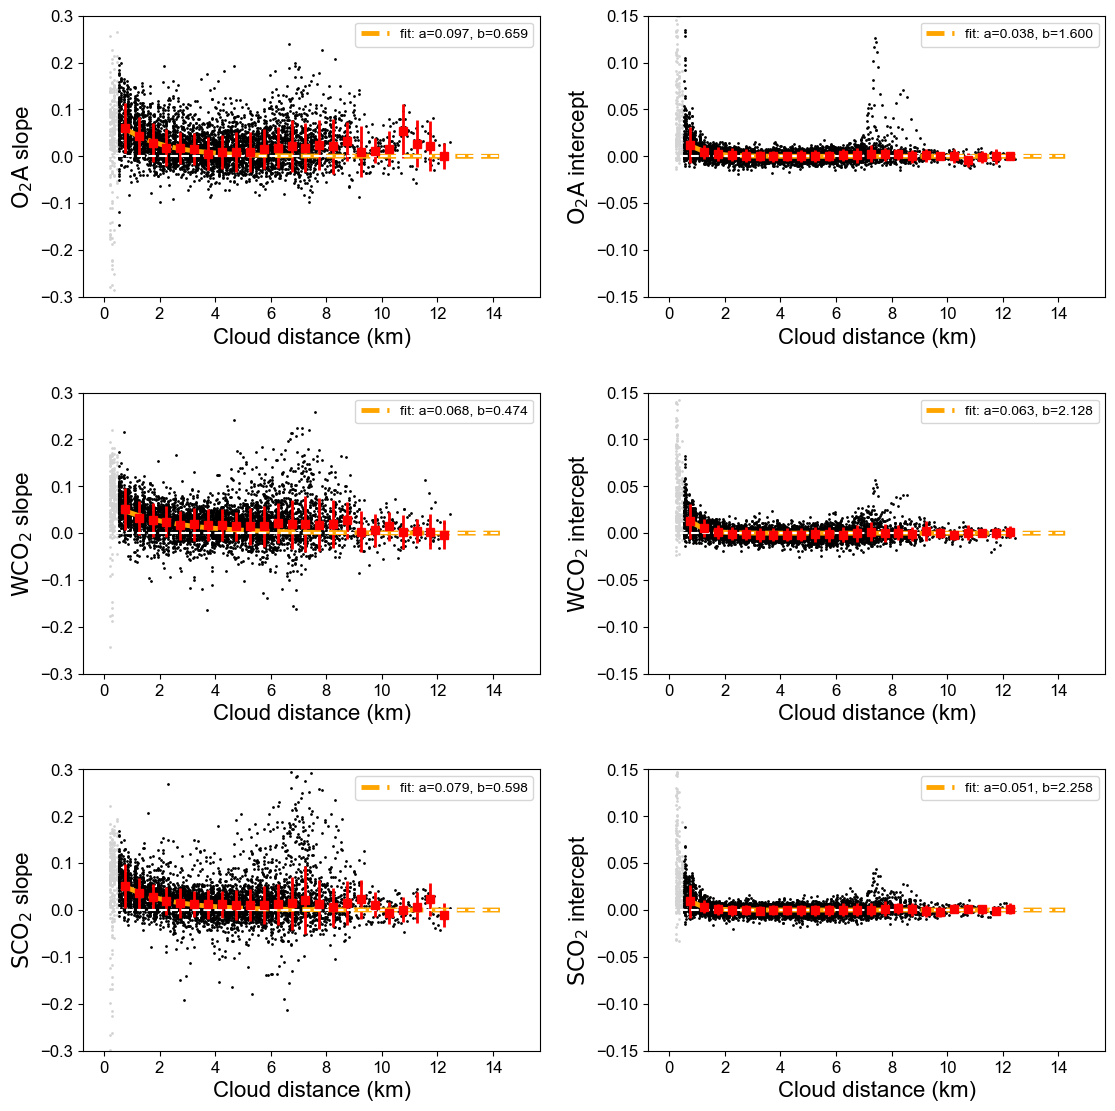

In [85]:
fig, ((ax11, ax12), 
      (ax21, ax22),
      (ax31, ax32)) = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.tight_layout(pad=5.0)
label_size = 16
tick_size = 12

cloud_dist = df_all.cld_dis
rad_3d = df_all.sco2_continuum_3d
rad_clr = df_all.sco2_continuum_clr

mask = cloud_dist > 0
mask = np.logical_and(cloud_dist > 0, rad_3d>rad_clr)

#"""

heatmap_xy_2(cloud_dist[mask], df_all.o2a_slope[mask], ax11)
heatmap_xy_2(cloud_dist[mask], df_all.o2a_inter[mask], ax12)
heatmap_xy_2(cloud_dist[mask], df_all.wco2_slope[mask], ax21)
heatmap_xy_2(cloud_dist[mask], df_all.wco2_inter[mask], ax22)
heatmap_xy_2(cloud_dist[mask], df_all.sco2_slope[mask], ax31)
heatmap_xy_2(cloud_dist[mask], df_all.sco2_inter[mask], ax32)
#"""


#popt, pcov = curve_fit(func, cloud_dist[mask], o1.slope_1km_all[:,:,0][mask])#, bounds=(0, [3., 1., 0.5]))

#ax11.plot(cloud_dist[mask], func(cloud_dist[mask], *popt), 'r--',
#          label='fit: a=%5.3f, b=%5.3ff' % tuple(popt))


"""
ax11.scatter(cloud_dist[mask], o1.slope_1km_all[:,:,0][mask])
ax12.scatter(cloud_dist[mask], o1.inter_1km_all[:,:,0][mask])
ax21.scatter(cloud_dist[mask], o2.slope_1km_all[:,:,0][mask])
ax22.scatter(cloud_dist[mask], o2.inter_1km_all[:,:,0][mask])
ax31.scatter(cloud_dist[mask], o3.slope_1km_all[:,:,0][mask])
ax32.scatter(cloud_dist[mask], o3.inter_1km_all[:,:,0][mask])
#"""
for ax in [ax11, ax21, ax31, ax12, ax22, ax32]:
    ax.set_xlabel('Cloud distance (km)', fontsize=label_size)
    ax.tick_params(axis='both', labelsize=tick_size)
    _, xmax = ax.get_xlim()
    ax.hlines(0, 0, xmax, linestyle='--', color='white')
    
ax11.set_ylabel('$\mathrm{O_2A}$ slope', fontsize=label_size)
ax12.set_ylabel('$\mathrm{O_2A}$ intercept', fontsize=label_size)
ax21.set_ylabel('$\mathrm{WCO_2}$ slope', fontsize=label_size)
ax22.set_ylabel('$\mathrm{WCO_2}$ intercept', fontsize=label_size)
ax31.set_ylabel('$\mathrm{SCO_2}$ slope', fontsize=label_size)
ax32.set_ylabel('$\mathrm{SCO_2}$ intercept', fontsize=label_size)

limit_1 = 0.3
limit_2 = 0.15
for ax in [ax11, ax21, ax31]:
    ax.set_ylim(-limit_1, limit_1)
    
for ax in [ax12, ax22, ax32]:
    ax.set_ylim(-limit_2, limit_2)

#ax.plot([20, 20], [0, 1.1], 'r')
#ax.plot([400, 400], [0, 1.1], 'r')
#ax.set_ylim(0, 1.1)
#ax.fill_between(t[2:41]*1e9, intensity[2:41], 0, color='lightgrey', interpolate=True)
#I0 = quad(intensity_fxn, 20e-9, 400e-9, args=(decay_const))[0]

#ax.set_yscale('log')
#fig.savefig('Q2.1-2.png', dpi=150, bbox_inches='tight')
plt.show()

In [159]:
def heatmap_xy_3(x, y, ax):
    from matplotlib.colors import LogNorm
    light_jet = cmap_map(lambda x: x/3*2 + 0.33, cm.jet)
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x, y = x[mask], y[mask]
    interval = 1/2
    start = 0.5
    
    
    # Calculate the point density
    data , x_e, y_e = np.histogram2d(x, y, bins=15)#, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    z[np.where(np.isinf(z))] = np.nanmax(z)
    z[np.where(z<0)] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    plot_x, plot_y, z = np.array(x)[idx], np.array(y)[idx], z[idx]
    #ax.scatter(plot_x, plot_y, c=z, s=15*z/np.nanmax(z), cmap=light_jet)
    
    
    
    ax.scatter(x[x<start], y[x<start], s=1, color='lightgrey')
    ax.scatter(x[x>=start], y[x>=start], s=1, color='k')
    #ax.hist2d(plot_x, plot_y, bins=150, norm=LogNorm(), cmap=light_jet)
    out = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    sns.kdeplot(out, x='x', y='y', cmap='hot_r', n_levels=20, fill=True, ax=ax, alpha=0.65)
    
    
    
    
    
    cld_levels = np.arange(start, 18, interval)
    value_avg, value_std = np.zeros(len(cld_levels)-1), np.zeros(len(cld_levels)-1)
    for i in range(len(cld_levels)-1):
        select = np.logical_and(x>=cld_levels[i], x < cld_levels[i+1])
        if select.sum()>0:
            #value_avg[i] = np.nanmean(y[select])
            #value_std[i] = np.nanstd(y[select])
            value_avg[i] = np.percentile(y[select], 50)
            value_std[i] = np.percentile(y[select], 75)-np.percentile(y[select], 25)
        else:
            value_avg[i] = np.nan
            value_std[i] = np.nan
    cld_list = (cld_levels[:-1] + cld_levels[1:])/2
    
    ax.errorbar(cld_list, value_avg, yerr=value_std, 
                marker='s', color='r', linewidth=2, linestyle='', ecolor='skyblue')#light_jet)
    
    val_mask = ~(np.isnan(value_avg) | np.isnan(value_std) | np.isinf(value_avg) | np.isinf(value_std))
    #print(value_avg[val_mask])
    #print(value_std[val_mask])
    temp_r2 = 0
    for cld_max in np.arange(3, 15, 0.5):
        cld_val = cld_list[val_mask]
        xx = cld_val[cld_val<=cld_max]
        yy = value_avg[val_mask][cld_val<=cld_max]
        popt, pcov = curve_fit(func, xx, yy, bounds=([-2, 0.], [2, 10,]),
                               p0=(0.1, 0.7),
                               maxfev=3000,
                               #sigma=value_std[val_mask], 
                               #absolute_sigma=True,
                              )
        residuals = yy - func(xx, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((yy-np.mean(yy))**2)
        r_squared = 1 - (ss_res / ss_tot)

        if r_squared > temp_r2:
            temp_r2 = r_squared
        else:
            break
    
    plot_xx = np.arange(0, cld_list.max()+0.75, 0.5)
    ax.plot(plot_xx, func(plot_xx, *popt), '--', color='limegreen', 
              label='fit: a=%5.3f\n     b=%5.3f' % tuple(popt), linewidth=3.5)
    print('-'*15)
    print(f'E-folding dis: {1/popt[1]}')
    #ax.plot(cld_list, func(cld_list, 1, 2), '--', color='green',)
    #ax.plot(cld_list, func(cld_list, 0.2, 1), '--', color='cyan',)
    ax.legend()
    return None#XX, YY, heatmap



from  scipy.optimize import curve_fit

def func(x, a, b):
     return a * np.exp(-b * x)

---------------
E-folding dis: 0.29107068768262745
---------------
E-folding dis: 0.8287375969057438
---------------
E-folding dis: 1.8677597696467594
---------------
E-folding dis: 0.8687537042534128
---------------
E-folding dis: 1.6267576978561373
---------------
E-folding dis: 0.8477375864531348


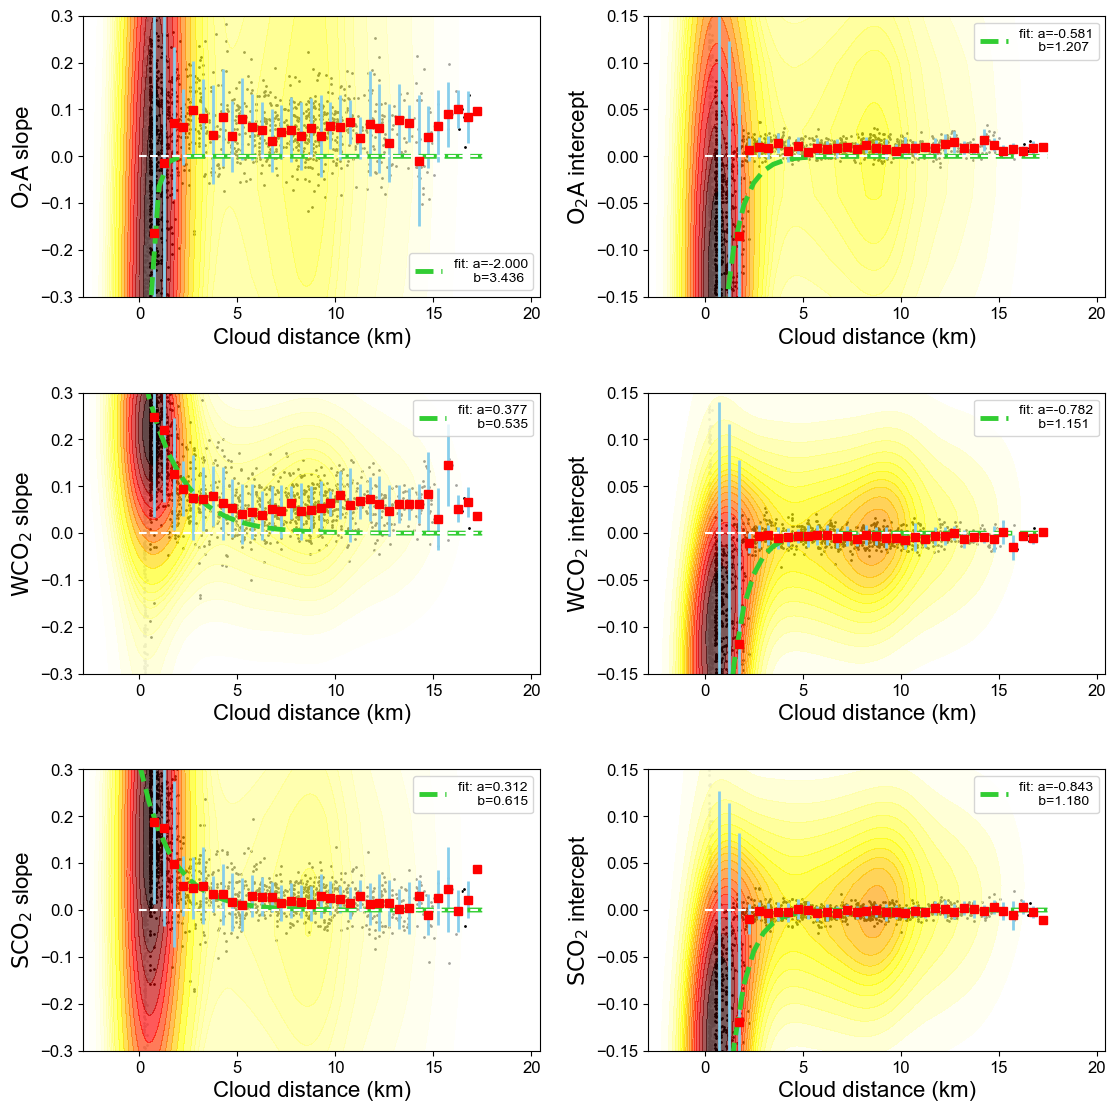

In [167]:
fig, ((ax11, ax12), 
      (ax21, ax22),
      (ax31, ax32)) = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.tight_layout(pad=5.0)
label_size = 16
tick_size = 12

cloud_dist = df_all.cld_dis
rad_3d = df_all.sco2_continuum_3d
rad_clr = df_all.sco2_continuum_clr

mask = cloud_dist > 0
mask = np.logical_and(cloud_dist > 0, rad_3d<rad_clr)

#"""

heatmap_xy_3(cloud_dist[mask], df_all.o2a_slope[mask], ax11)
heatmap_xy_3(cloud_dist[mask], df_all.o2a_inter[mask], ax12)
heatmap_xy_3(cloud_dist[mask], df_all.wco2_slope[mask], ax21)
heatmap_xy_3(cloud_dist[mask], df_all.wco2_inter[mask], ax22)
heatmap_xy_3(cloud_dist[mask], df_all.sco2_slope[mask], ax31)
heatmap_xy_3(cloud_dist[mask], df_all.sco2_inter[mask], ax32)
#"""


#popt, pcov = curve_fit(func, cloud_dist[mask], o1.slope_1km_all[:,:,0][mask])#, bounds=(0, [3., 1., 0.5]))

#ax11.plot(cloud_dist[mask], func(cloud_dist[mask], *popt), 'r--',
#          label='fit: a=%5.3f, b=%5.3ff' % tuple(popt))


"""
ax11.scatter(cloud_dist[mask], o1.slope_1km_all[:,:,0][mask])
ax12.scatter(cloud_dist[mask], o1.inter_1km_all[:,:,0][mask])
ax21.scatter(cloud_dist[mask], o2.slope_1km_all[:,:,0][mask])
ax22.scatter(cloud_dist[mask], o2.inter_1km_all[:,:,0][mask])
ax31.scatter(cloud_dist[mask], o3.slope_1km_all[:,:,0][mask])
ax32.scatter(cloud_dist[mask], o3.inter_1km_all[:,:,0][mask])
#"""
for ax in [ax11, ax21, ax31, ax12, ax22, ax32]:
    ax.set_xlabel('Cloud distance (km)', fontsize=label_size)
    ax.tick_params(axis='both', labelsize=tick_size)
    _, xmax = ax.get_xlim()
    ax.hlines(0, 0, xmax, linestyle='--', color='white')
    
ax11.set_ylabel('$\mathrm{O_2A}$ slope', fontsize=label_size)
ax12.set_ylabel('$\mathrm{O_2A}$ intercept', fontsize=label_size)
ax21.set_ylabel('$\mathrm{WCO_2}$ slope', fontsize=label_size)
ax22.set_ylabel('$\mathrm{WCO_2}$ intercept', fontsize=label_size)
ax31.set_ylabel('$\mathrm{SCO_2}$ slope', fontsize=label_size)
ax32.set_ylabel('$\mathrm{SCO_2}$ intercept', fontsize=label_size)

limit_1 = 0.3
limit_2 = 0.15
for ax in [ax11, ax21, ax31]:
    ax.set_ylim(-limit_1, limit_1)
    
for ax in [ax12, ax22, ax32]:
    ax.set_ylim(-limit_2, limit_2)

#ax.plot([20, 20], [0, 1.1], 'r')
#ax.plot([400, 400], [0, 1.1], 'r')
#ax.set_ylim(0, 1.1)
#ax.fill_between(t[2:41]*1e9, intensity[2:41], 0, color='lightgrey', interpolate=True)
#I0 = quad(intensity_fxn, 20e-9, 400e-9, args=(decay_const))[0]

#ax.set_yscale('log')
#fig.savefig('Q2.1-2.png', dpi=150, bbox_inches='tight')
plt.show()